In [1]:
pwd

'/home/gdolle/code/G-Dolle/DIVVY_BIKE/notebooks'

In [2]:
cd '/home/gdolle/code/G-Dolle/DIVVY_BIKE'

/home/gdolle/code/G-Dolle/DIVVY_BIKE


In [3]:
from divvy.ml_logic.data_import import get_station_data
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
station_df = get_station_data()

In [5]:
station_df.head(2)

,Unnamed: 0,external_id,station_id,short_name,eightd_has_key_dispenser,legacy_id,electric_bike_surcharge_waiver,capacity,has_kiosk,rental_methods,...,station_type,eightd_station_services,region_id,region_code,address,dockless_bikes_parking_zone_capacity,rack_model,client_station_id,target_bike_capacity,target_scooter_capacity
0,0,a3b1c47b-a135-11e9-9cda-0a87ae2ba916,a3b1c47b-a135-11e9-9cda-0a87ae2ba916,16915,False,541,False,11,True,"['KEY', 'CREDITCARD', 'TRANSITCARD']",...,classic,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,a3b2d2b7-a135-11e9-9cda-0a87ae2ba916,a3b2d2b7-a135-11e9-9cda-0a87ae2ba916,593,False,593,False,11,True,"['KEY', 'CREDITCARD', 'TRANSITCARD']",...,classic,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
condition = station_df.capacity > 10

In [25]:
station_df = station_df[condition]

In [26]:
station_df.capacity.value_counts()

15    269
11    175
19     97
23     49
27     24
31     19
39     11
35      6
12      6
47      4
43      4
55      3
16      3
20      2
51      1
32      1
Name: capacity, dtype: int64

In [27]:
station_df_red = station_df[["lat","lon"]]

In [28]:
from folium import Map, plugins

m = Map([41.8781, -87.6298], zoom_start=8)

# convert to (n, 2) nd-array format for heatmap
stationArr = station_df_red.values

# plot heatmap
m.add_child(plugins.HeatMap(stationArr, radius=11))

<AxesSubplot: xlabel='lon', ylabel='lat'>

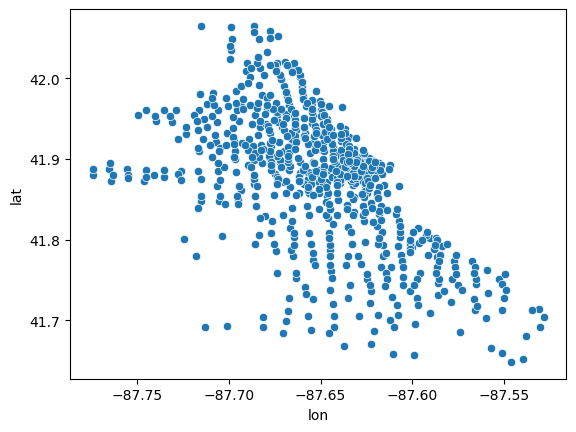

In [29]:
sns.scatterplot(x=station_df["lon"],y=station_df["lat"])

<AxesSubplot: xlabel='lon', ylabel='lat'>

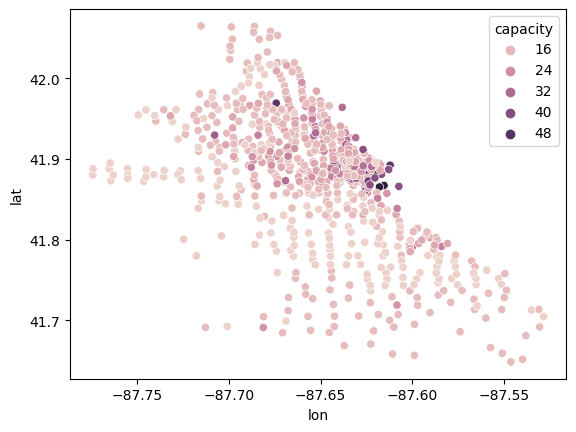

In [30]:
sns.scatterplot(x=station_df["lon"],y=station_df["lat"], hue=station_df["capacity"])

In [36]:
pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 9.2 MB/s eta 0:00:0000:0100:01m
  Using cached tenacity-8.1.0-py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.


In [31]:
import pygeohash as gh

In [33]:
station_df["geohash"] = station_df.apply(lambda x: gh.encode(x.lat,
                                                                x.lon,
                                                                precision=4),
                                            axis=1)

In [46]:
print(station_df["lat"].min())
print(station_df["lon"].min())



41.64850076266409
-87.774453


In [47]:
print(station_df["lat"].max())
print(station_df["lon"].max())


42.064854
-87.52823173999786


<AxesSubplot: xlabel='lon', ylabel='lat'>

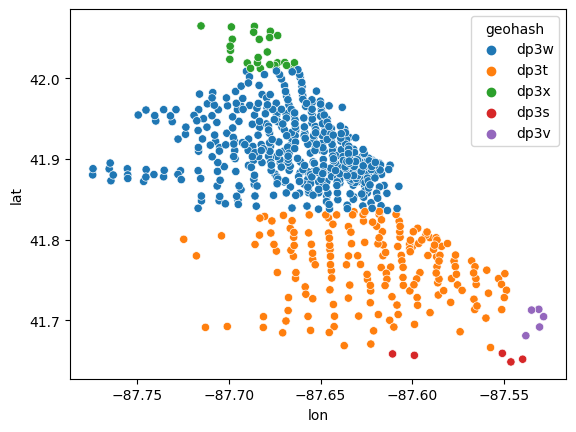

In [34]:
sns.scatterplot(x=station_df["lon"],y=station_df["lat"], hue=station_df["geohash"])

In [9]:
from divvy.interface_ui.flow.ui_utils import get_retained_geohash
import os

In [10]:
quarter= os.environ.get("DIVVY_QUARTER")
year= os.environ.get("DIVVY_YEAR")

In [11]:
import os
import pandas as pd
import numpy as np
import math

from divvy.ml_logic.data_import import get_weather_data, get_divvy_data
from divvy.ml_logic.cleaning import compute_geohash_stations,weather_cleaning, cleaning_divvy_gen,cleaning_divvy_gen_agg, merge_divvy_weather, features_target
from divvy.ml_logic.preprocessor import transform_time_features, preprocess_features, target_process

In [12]:
target_chosen="nb_arrivals"

quarter= os.environ.get("DIVVY_QUARTER")
year= os.environ.get("DIVVY_YEAR")

raw_divvy_df = get_divvy_data(year,quarter)
raw_weather_df = get_weather_data()

print("Raw data imported")

# Clean data & merge data

clean_divvy_df = cleaning_divvy_gen_agg(raw_divvy_df)
clean_weather_df = weather_cleaning(raw_weather_df)

merged_df = merge_divvy_weather(clean_divvy_df, clean_weather_df)

Raw data imported


/home/gdolle/code/G-Dolle/DIVVY_BIKE/divvy/ml_logic/cleaning.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stations_reduced.rename(columns={"name":"station_name"}, inplace=True)


In [18]:
raw_divvy_df.head(2)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,hourly_data_started,hourly_data_ended
0,9DC7B962304CBFD8,electric_bike,2021-09-28 16:07:10,2021-09-28 16:09:54,NaN,NaN,NaN,NaN,41.89,-87.68,41.89,-87.67,casual,2021-09-28 16:00:00,2021-09-28 16:00:00
1,F930E2C6872D6B32,electric_bike,2021-09-28 14:24:51,2021-09-28 14:40:05,NaN,NaN,NaN,NaN,41.94,-87.64,41.98,-87.67,casual,2021-09-28 14:00:00,2021-09-28 15:00:00


In [14]:
station_df_reduced=station_df[["name","lat","lon"]]
station_df_reduced.rename(columns={"name":"station_name"}, inplace=True)

/tmp/ipykernel_16602/3258416279.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  station_df_reduced.rename(columns={"name":"station_name"}, inplace=True)


In [15]:
merged_df = merged_df.merge(station_df_reduced, how="left", on="station_name")

KeyError: 'station_name'

In [48]:
import PIL
import numpy as np

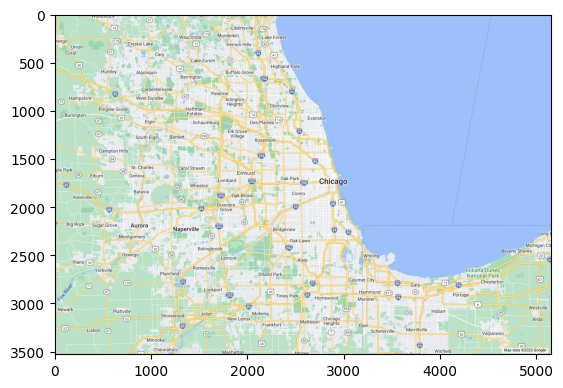

In [50]:
bounding_boxes = (-88.373455, -87.094921, 41.637692, 42.102986)

chicago_map = np.array(PIL.Image.open("raw_data/Chicago_map.png"))

plt.imshow(chicago_map);

In [65]:
def plot_on_map(df, BB, chicago_map, s=10, alpha=0.2):
    plt.figure(figsize=(16,10))

    plt.scatter(df.lon, df.lat, zorder=1, alpha=alpha, c='red', s=s)
    plt.xlim((BB[0], BB[1]))
    plt.ylim((BB[2], BB[3]))
    plt.title('Pickup locations')
    plt.imshow(chicago_map, zorder=0, extent=BB)



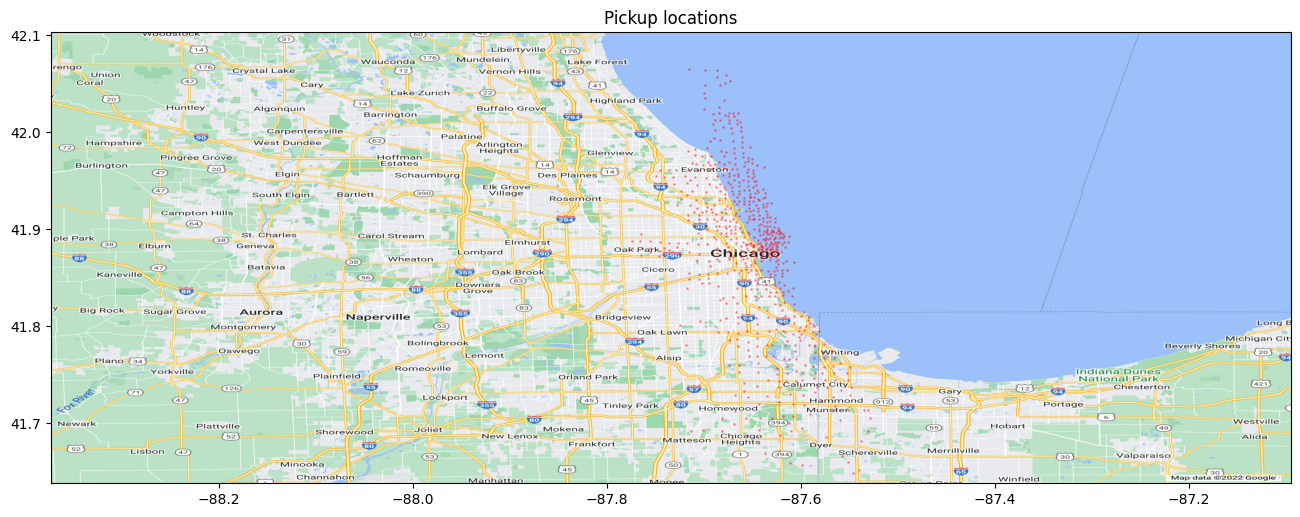

In [66]:
plot_on_map(station_df, bounding_boxes, chicago_map, s=1, alpha=0.3)